# Importar dados

In [17]:
import numpy as np

In [18]:

feature = np.load('data/feature.npy')
target = np.load('data/target.npy')


# Infraestrutura dos dados (dataloader)

## Normalizando

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
# Normalização das features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(feature.reshape(-1, feature.shape[-1])).reshape(feature.shape)
y_scaled = scaler_y.fit_transform(target)

## Criando um dataSet e utilizando o dataloader

In [21]:
from torch.utils.data import DataLoader, Dataset

In [22]:
class CustomDataset(Dataset):
    def __init__(self, feature, label):
        self.feature = feature
        self.label = label

    def __len__(self):
        return len(self.feature)

    def __getitem__(self, index):
        return self.feature[index], self.label[index]

# Modelo

In [23]:
from torch import nn

In [24]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.linear(lstm_out[:, -1, :])

# Funções

## Treino

In [25]:
import torch

In [26]:
def train(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0.0
    for data, target in dataloader:
        data, target = data.float().to(device), target.float().to(device)
        optimizer.zero_grad()
        predictions = model(data)
        loss = loss_fn(predictions, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


## Teste

In [27]:
def test(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.float().to(device), target.float().to(device)
            predictions = model(data)
            loss = loss_fn(predictions, target)
            total_loss += loss.item()
    return total_loss / len(dataloader)

## Criação dos Graficos

In [28]:
import matplotlib.pyplot as plt

In [29]:
def plot_results(val_losses, train_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(val_losses, label='Validation Loss', marker='o')
    plt.title("Validation Loss Across Folds")
    plt.xlabel("Fold")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    for fold, losses in enumerate(train_losses):
        plt.plot(losses, label=f'Training Loss (Fold {fold+1})', marker='o')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

## Criando a Cross Validation

In [30]:
from sklearn.model_selection import TimeSeriesSplit

In [31]:
def cross_validation_time_series(X, y, n_splits=5, batch_size=32, epochs=200):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    val_losses = []
    train_losses = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f"Fold {fold+1}/{n_splits}")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        train_dataset = CustomDataset(X_train, y_train)
        val_dataset = CustomDataset(X_val, y_val)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        input_size = X.shape[2]
        output_size = y.shape[1]
        model = LSTMModel(input_size=input_size, hidden_size=50, output_size=output_size).to(device)

        loss_fn = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        fold_train_losses = []

        for epoch in range(epochs):
            train_loss = train(model, train_dataloader, loss_fn, optimizer, device)
            fold_train_losses.append(train_loss)

            if epoch % 50 == 0:
                print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}")

        val_loss = test(model, val_dataloader, loss_fn, device)
        print(f"Validation Loss for fold {fold+1}: {val_loss:.4f}")

        val_losses.append(val_loss)
        train_losses.append(fold_train_losses)

    avg_val_loss = np.mean(val_losses)
    print(f"Average Validation Loss: {avg_val_loss:.4f}")

    plot_results(val_losses, train_losses)

# Executando

Fold 1/5
Epoch 0/200, Train Loss: 0.1412
Epoch 50/200, Train Loss: 0.0014
Epoch 100/200, Train Loss: 0.0006
Epoch 150/200, Train Loss: 0.0005
Validation Loss for fold 1: 0.0229
Fold 2/5
Epoch 0/200, Train Loss: 0.0882
Epoch 50/200, Train Loss: 0.0009
Epoch 100/200, Train Loss: 0.0005
Epoch 150/200, Train Loss: 0.0005
Validation Loss for fold 2: 0.0197
Fold 3/5
Epoch 0/200, Train Loss: 0.1253
Epoch 50/200, Train Loss: 0.0011
Epoch 100/200, Train Loss: 0.0012
Epoch 150/200, Train Loss: 0.0007
Validation Loss for fold 3: 0.0105
Fold 4/5
Epoch 0/200, Train Loss: 0.0854
Epoch 50/200, Train Loss: 0.0016
Epoch 100/200, Train Loss: 0.0013
Epoch 150/200, Train Loss: 0.0015
Validation Loss for fold 4: 0.0049
Fold 5/5
Epoch 0/200, Train Loss: 0.0851
Epoch 50/200, Train Loss: 0.0025
Epoch 100/200, Train Loss: 0.0014
Epoch 150/200, Train Loss: 0.0013
Validation Loss for fold 5: 0.0192
Average Validation Loss: 0.0154


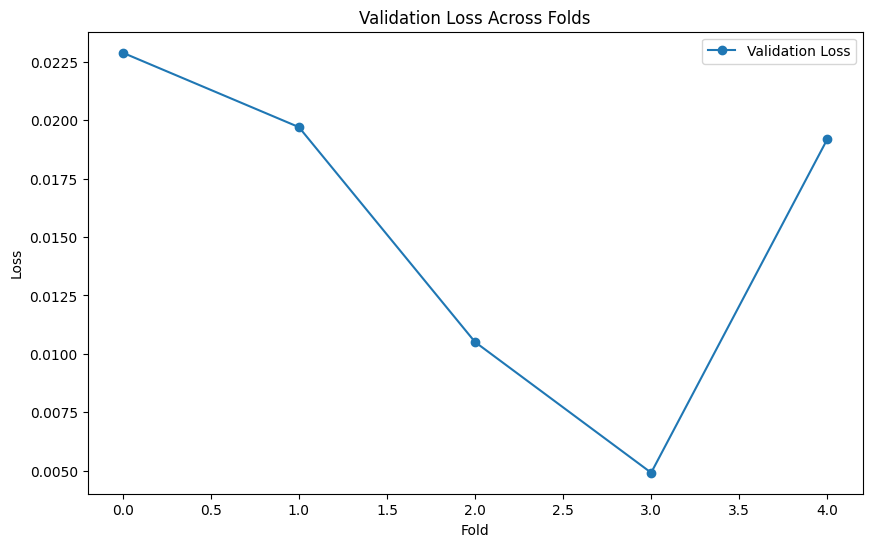

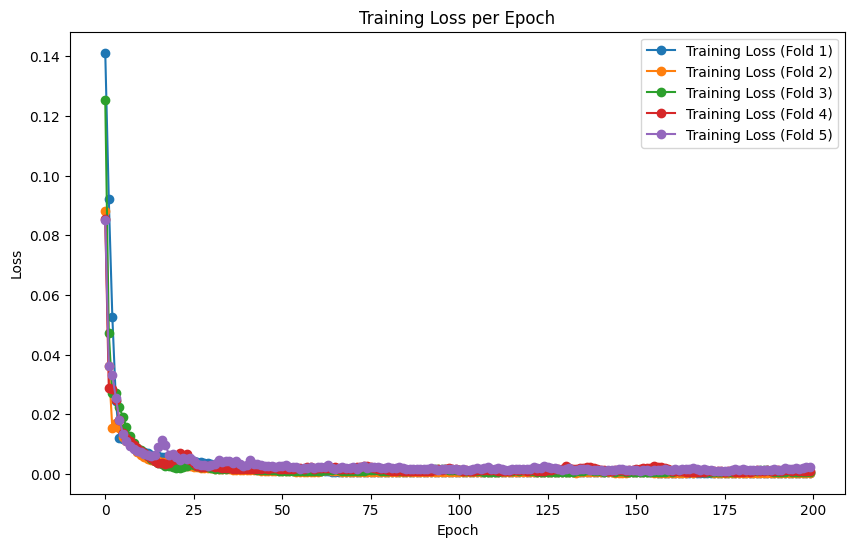

In [32]:
cross_validation_time_series(X_scaled, y_scaled, n_splits=5, batch_size=128, epochs=200)